In [1]:
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path
import glob
import json
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sn
import krippendorff as kd

## Let's compute the annotator agreement

In [2]:
"""
Separating the list of lists
"""
def schools(path):
    f = open(path)
    Json_Data = json.load(f)
    res = []
    for key, val in Json_Data.items():
        res.append([key] + val)

    tenca1 = res[0][1:]
    tenca2 = res[1][1:]
    majorana_setti1 = res[2][1:]
    alessandrini_titolivio1 = res[3][1:]
    mariecurie_cernusco1 = res[4][1:]
    tenca3 = res[5][1:]
    bachelet_abbiategrasso = res[6][1:]
    
    return tenca1,tenca2,majorana_setti1,alessandrini_titolivio1,mariecurie_cernusco1,tenca3,bachelet_abbiategrasso

In [3]:
"""
Creating the precdiction list of the schools set using mode
"""

def Mode(list):
    
    mode_list = []
    for i in list:
        j = st.mode(i)
        mode_list.append(j)
    
    return mode_list

## `true_annotations` computes the most common annotations for each sample (the reference annotations)

In [4]:

"""
Creating the true annotation set using mode
""" 
def true_annotations(tenca1,tenca2,majorana_setti1,alessandrini_titolivio1,mariecurie_cernusco1,tenca3,bachelet_abbiategrasso):  
    true_list = []
    track = []
    for i in range(0,500):
        track.append(tenca1[i]+tenca2[i]+majorana_setti1[i]+alessandrini_titolivio1[i]+mariecurie_cernusco1[i]+tenca3[i]+bachelet_abbiategrasso[i])
    
    true_list= Mode(track) 
    
    return true_list

## `predicted_annotations` computes a reference annotation for each school

In [5]:
def predicted_annotations(tenca1,tenca2,majorana_setti1,alessandrini_titolivio1,mariecurie_cernusco1,tenca3,bachelet_abbiategrasso):
    Tenca1 = Mode(tenca1)
    Tenca2 = Mode(tenca2)
    Majorana_Setti1 = Mode(majorana_setti1)
    Alessandrini_Titolivio1 = Mode(alessandrini_titolivio1)
    Mariecurie_Cernusco1 = Mode(mariecurie_cernusco1)
    Tenca3 = Mode(tenca3)
    Bachelet_Abbiategrasso = Mode(bachelet_abbiategrasso)

    school_list = [Tenca1, Tenca2, Majorana_Setti1, Alessandrini_Titolivio1, Mariecurie_Cernusco1, Tenca3, Bachelet_Abbiategrasso]
    return school_list

In [6]:
def plot_intra_rater_agreement(bar_list, names):
    plt.figure(figsize=(10, 8))  # smaller plot size
    plt.bar(names, bar_list, color='black')  # plotting in black
    plt.xlabel('School Names', fontsize=14)  # smaller font size for labels
    plt.ylabel('Krippendorff\'s alpha', fontsize=14)  # smaller font size for labels
    plt.xticks(rotation=45, ha='right', fontsize=12)  # rotate x-axis labels for better visibility
    plt.yticks(fontsize=12)  # smaller font size for y-axis ticks
    plt.tight_layout()  # adjust layout to prevent overlap
    plt.show()

In [7]:
"""    
Annonator asgreement
"""
def IntraRater(list_of_lists):#Intra Rater
    min_len = min(len(L) for L in list_of_lists)
    list_of_lists = [L[:min_len] for L in list_of_lists]
    agreement = kd.alpha(np.array(list_of_lists).T)
   
    return agreement


In [8]:
path = './__annotator.json'

"""
"Page border"= 0
Erasure = 1
Burr = 2
"Printed Text" = 3
"Manuscript Text" = 4
"Pause (full or almost)" = 5
"Single note (with at least the head)" = 6
"Multiple Notes (with at least the head)" = 7
"Single chord (with at least heads)" = 8
"Multiple chords (with at least heads)" = 9
"Accidental(s) (whole or nearly so)" = 10
"Key(s) (whole(s) or nearly)" = 11
"Embellishment(s) (whole(s) or nearly)" = 12
"More categories (with at least one musical score)" = 14
"More categories (no musical scores)" = 15
"Other (with at least one musical score)" = 16
"Other (without musical markings)" = 17
"""    


classes_relevant = [5,6,7,8,9,11,12,13,14,16]
classes_irrelevant = [0,1,2,3,4,15,17]

classes = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']

num_classes = len(classes)

In [9]:
schools_ = schools(path)

In [10]:
def rater_agreement(schools):
    school_list = predicted_annotations(*schools_)
    print("Inter-Rater agreement: ",kd.alpha(np.array(school_list)))  #Inter-Annotator agreement assuming nominal categories
    bar_list = [IntraRater(school) for school in schools_]
    print("Intra-Rater agreement between:", min(bar_list), "and", max(bar_list))
    
    names = ['tenca1','tenca2','majorana_setti1','alessandrini_titolivio1','mariecurie_cernusco1',
             'tenca3','bachelet_abbiategrasso']
    
    plot_intra_rater_agreement(bar_list, names)

Inter-Rater agreement:  0.7225031997537045
Intra-Rater agreement between: 0.5244233623202286 and 0.7072638342132248


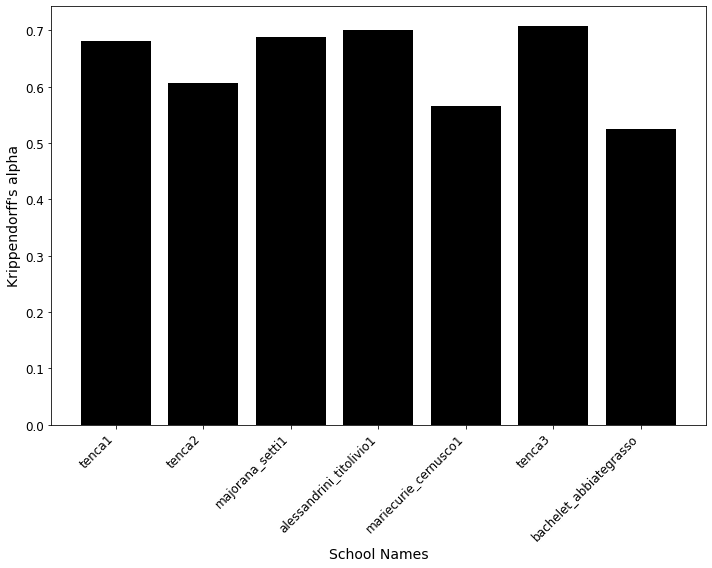

In [11]:
rater_agreement(schools_)

## Now, let's try to merge classes to increase the annotator's agreement

In [12]:
def confusion_matrix(classes, true_list, *schools):
    """Computes the confusion matrix between all the annotations given and the reference annotations"""
    #Visualize actual cnfusion matrix
    num_classes = len(classes)
    C_M = pd.DataFrame(np.zeros((num_classes,num_classes), dtype = int), 
                       index = classes, columns = classes)
    for school in schools:
        for i, sample in enumerate(school):
            for p_label in sample:
                t_label = true_list[i]
                C_M.loc[str(t_label), str(p_label)] += 1

    C_M_Normalized = C_M.astype('float') / C_M.max(axis=1).to_numpy()[:, np.newaxis]
    C_M_Normalized[np.isnan(C_M_Normalized)] = 0
    C_M_Normalized = np.round(C_M_Normalized, 3)
    
    return C_M_Normalized


In [13]:
def plot_confusion_matrix(C_M):
    def plot_(C_M):
        
        fig = plt.figure(figsize=(30, 20))
        ax = plt.subplot()
        sn.heatmap(C_M, annot=True, ax = ax, fmt = 'g')
        ax.set_xlabel('Predicted Annotations', fontsize=40)
        ax.xaxis.set_label_position('bottom')

        ax.set_ylabel('Actual Annotations', fontsize=40)

        plt.title('Refined Confusion Matrix', fontsize=60)
        plt.show()

    print(C_M)
    plot_(C_M)

In [14]:
true_list = true_annotations(*schools_)
CM = confusion_matrix(classes, true_list, *schools_)
# plot_confusion_matrix(CM)

In [15]:
def find_merge_classes(CM, threshold):
    merges = []
    
    for i in range(CM.shape[0]):
        for j in range(CM.shape[1]):
            if j >= i:
                break
            if CM.iloc[i, j] >= threshold:
                merges.append((i, j))
                print(f"Merging {i} and {j}")
    return merges

def apply_merge_classes(merges, *schools):
    for school in schools_:
        for sample in school:
            for i, annotation in enumerate(sample):
                for m in merges:
                    if annotation in m[1:]:
                        sample[i] = m[0]

In [16]:
th = 0.5
while True:
    true_list = true_annotations(*schools_)
    CM = confusion_matrix(classes, true_list, *schools_) 
    merges = find_merge_classes(CM, th)
    if len(merges) > 0:
        apply_merge_classes(merges, *schools_)
    else:
        break

Merging 9 and 7
Merging 15 and 2


Inter-Rater agreement:  0.8414416157350559
Intra-Rater agreement between: 0.6346659126392886 and 0.7924636853076763


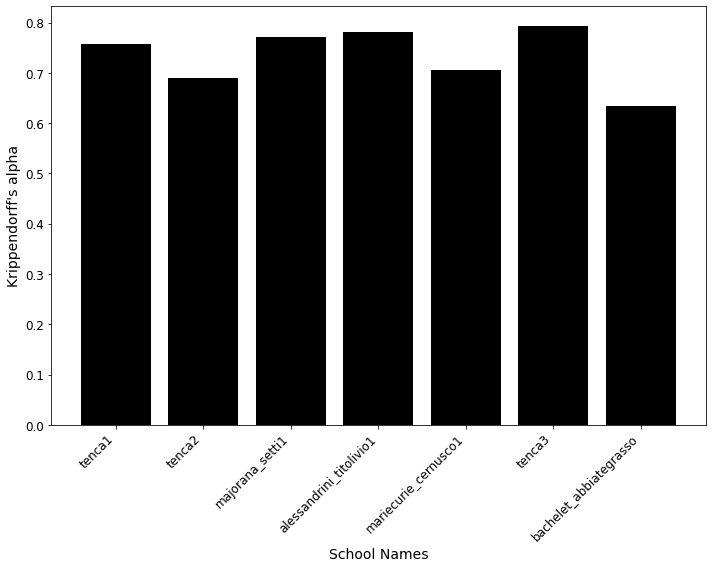

In [17]:
rater_agreement(schools_)

## Now computing agreement for the binary classification

Inter-Rater agreement:  0.8955558019342623
Intra-Rater agreement between: 0.7392941728195668 and 0.7917534931473031


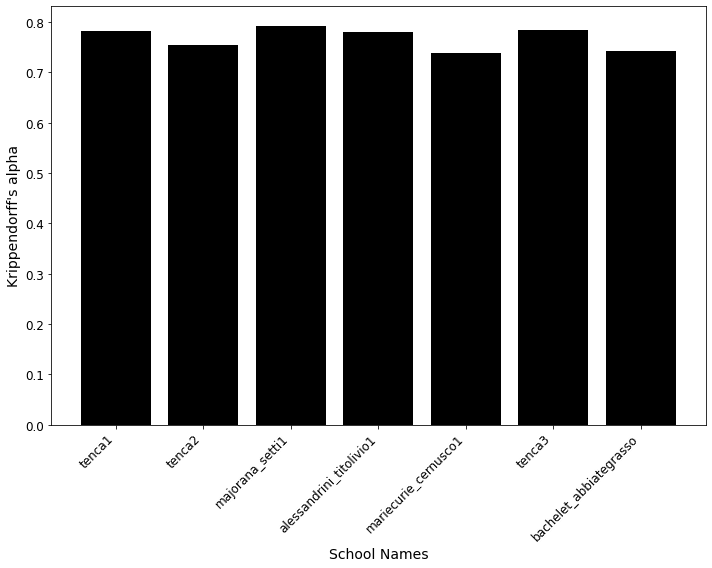

In [18]:
merges = (
    classes_relevant, classes_irrelevant
)
apply_merge_classes(merges, *schools_)
rater_agreement(schools_)